### Mathematical Derivation

For an M/M/1 queue, the mean waiting time $\mathbb{E}(W)_{1}$ is equal to:
$$
\mathbb{E}(W)_{1} = \mathbb{E}(S)_{1} - \frac{1}{\mu} = \frac{\rho}{1+\rho} - \frac{1}{\mu} = \frac{\rho}{\mu (1 - \rho)}
$$
where:
- $\mathbb{E}(S)_{1}$ is the mean total time spent in the system in a an M/M/1 queue,
- $\frac{1}{\mu}$ is the mean service time,
- $\rho$ is the utilization rate, and
- $\mu$ is the service rate (capacity of the server).

For an M/M/c queue with c servers, Little's law allow us to see that the mean waiting time $\mathbb{E}(W)_{c}$ is equal to:
$$
E(W)_{c} = \Pi_{W_c} \cdot \frac{1}{1 - \rho} \cdot \frac{1}{c \mu}
$$
where:
- $\Pi_{W_c}$ is the probability that a job has to wait, referred to as the delay probability, and is equal to: 
$$
\frac{(c\rho)^c}{c!} \left( (1 - \rho) \sum_{n=0}^{c-1} \frac{(c\rho)^n}{n!} + \frac{(c\rho)^c}{c!} \right)^{-1}
$$
For example, the mean waiting time for a M/M/2 system would be $\mathbb{E}(S)_{2} = \Pi_{W_2} \cdot \frac{1}{1 - \rho} \cdot \frac{1}{2 \mu}$ with:

$\Pi_{W_2} = \frac{(2\rho)^2}{2!} \left( (1 - \rho) \sum_{n=0}^{1} \frac{(2\rho)^n}{n!} + \frac{(2\rho)^2}{2!} \right)^{-1} = \frac{2\rho^2}{(1 - \rho)(1 + 2\rho) + 2\rho^2} = \frac{{2\rho^2}}{(1 + \rho - 2\rho^2) + 2\rho^2} = \frac{{2\rho^2}}{(1 + \rho)}$. 

Thus, the mean waiting time for an M/M/2 queue system is equal to: $\mathbb{E}(S)_{2} = \frac{{\rho^2}}{(1 + \rho)} \cdot \frac{1}{1 - \rho} \cdot \frac{1}{\mu}$. 

The ratio of $\mathbb{E}(S)$ of M/M/1 and of M/M/2 is equal to: $\frac{\mathbb{E}(S)_{2}}{\mathbb{E}(S)_{1}}=\frac{\rho}{1+\rho}$. For a utilization rate $\rho \approx	1$, $\frac{\rho}{1+\rho} \approx \frac{1}{2}$, meaning the mean waiting time $\mathbb{E}(S)_{2}$ of the M/M/2 system is approximately half of that of an M/M/1 queuing system ($\mathbb{E}(S)_{1}$)if both are with a high utilization rate. 

A non-mathematical explanation of why, for FIFO scheduling, the average waiting times are shorter for an M/M/c queue and a system load ρ and processor capacity μ than for a single M/M/1 queue with the same load characteristics and $\rho < 1$ is that with multiple servers, the workload can be divided, and parallel processing helps mitigate bottlenecks encountered when $\rho$ is high.

In [13]:
import simpy
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

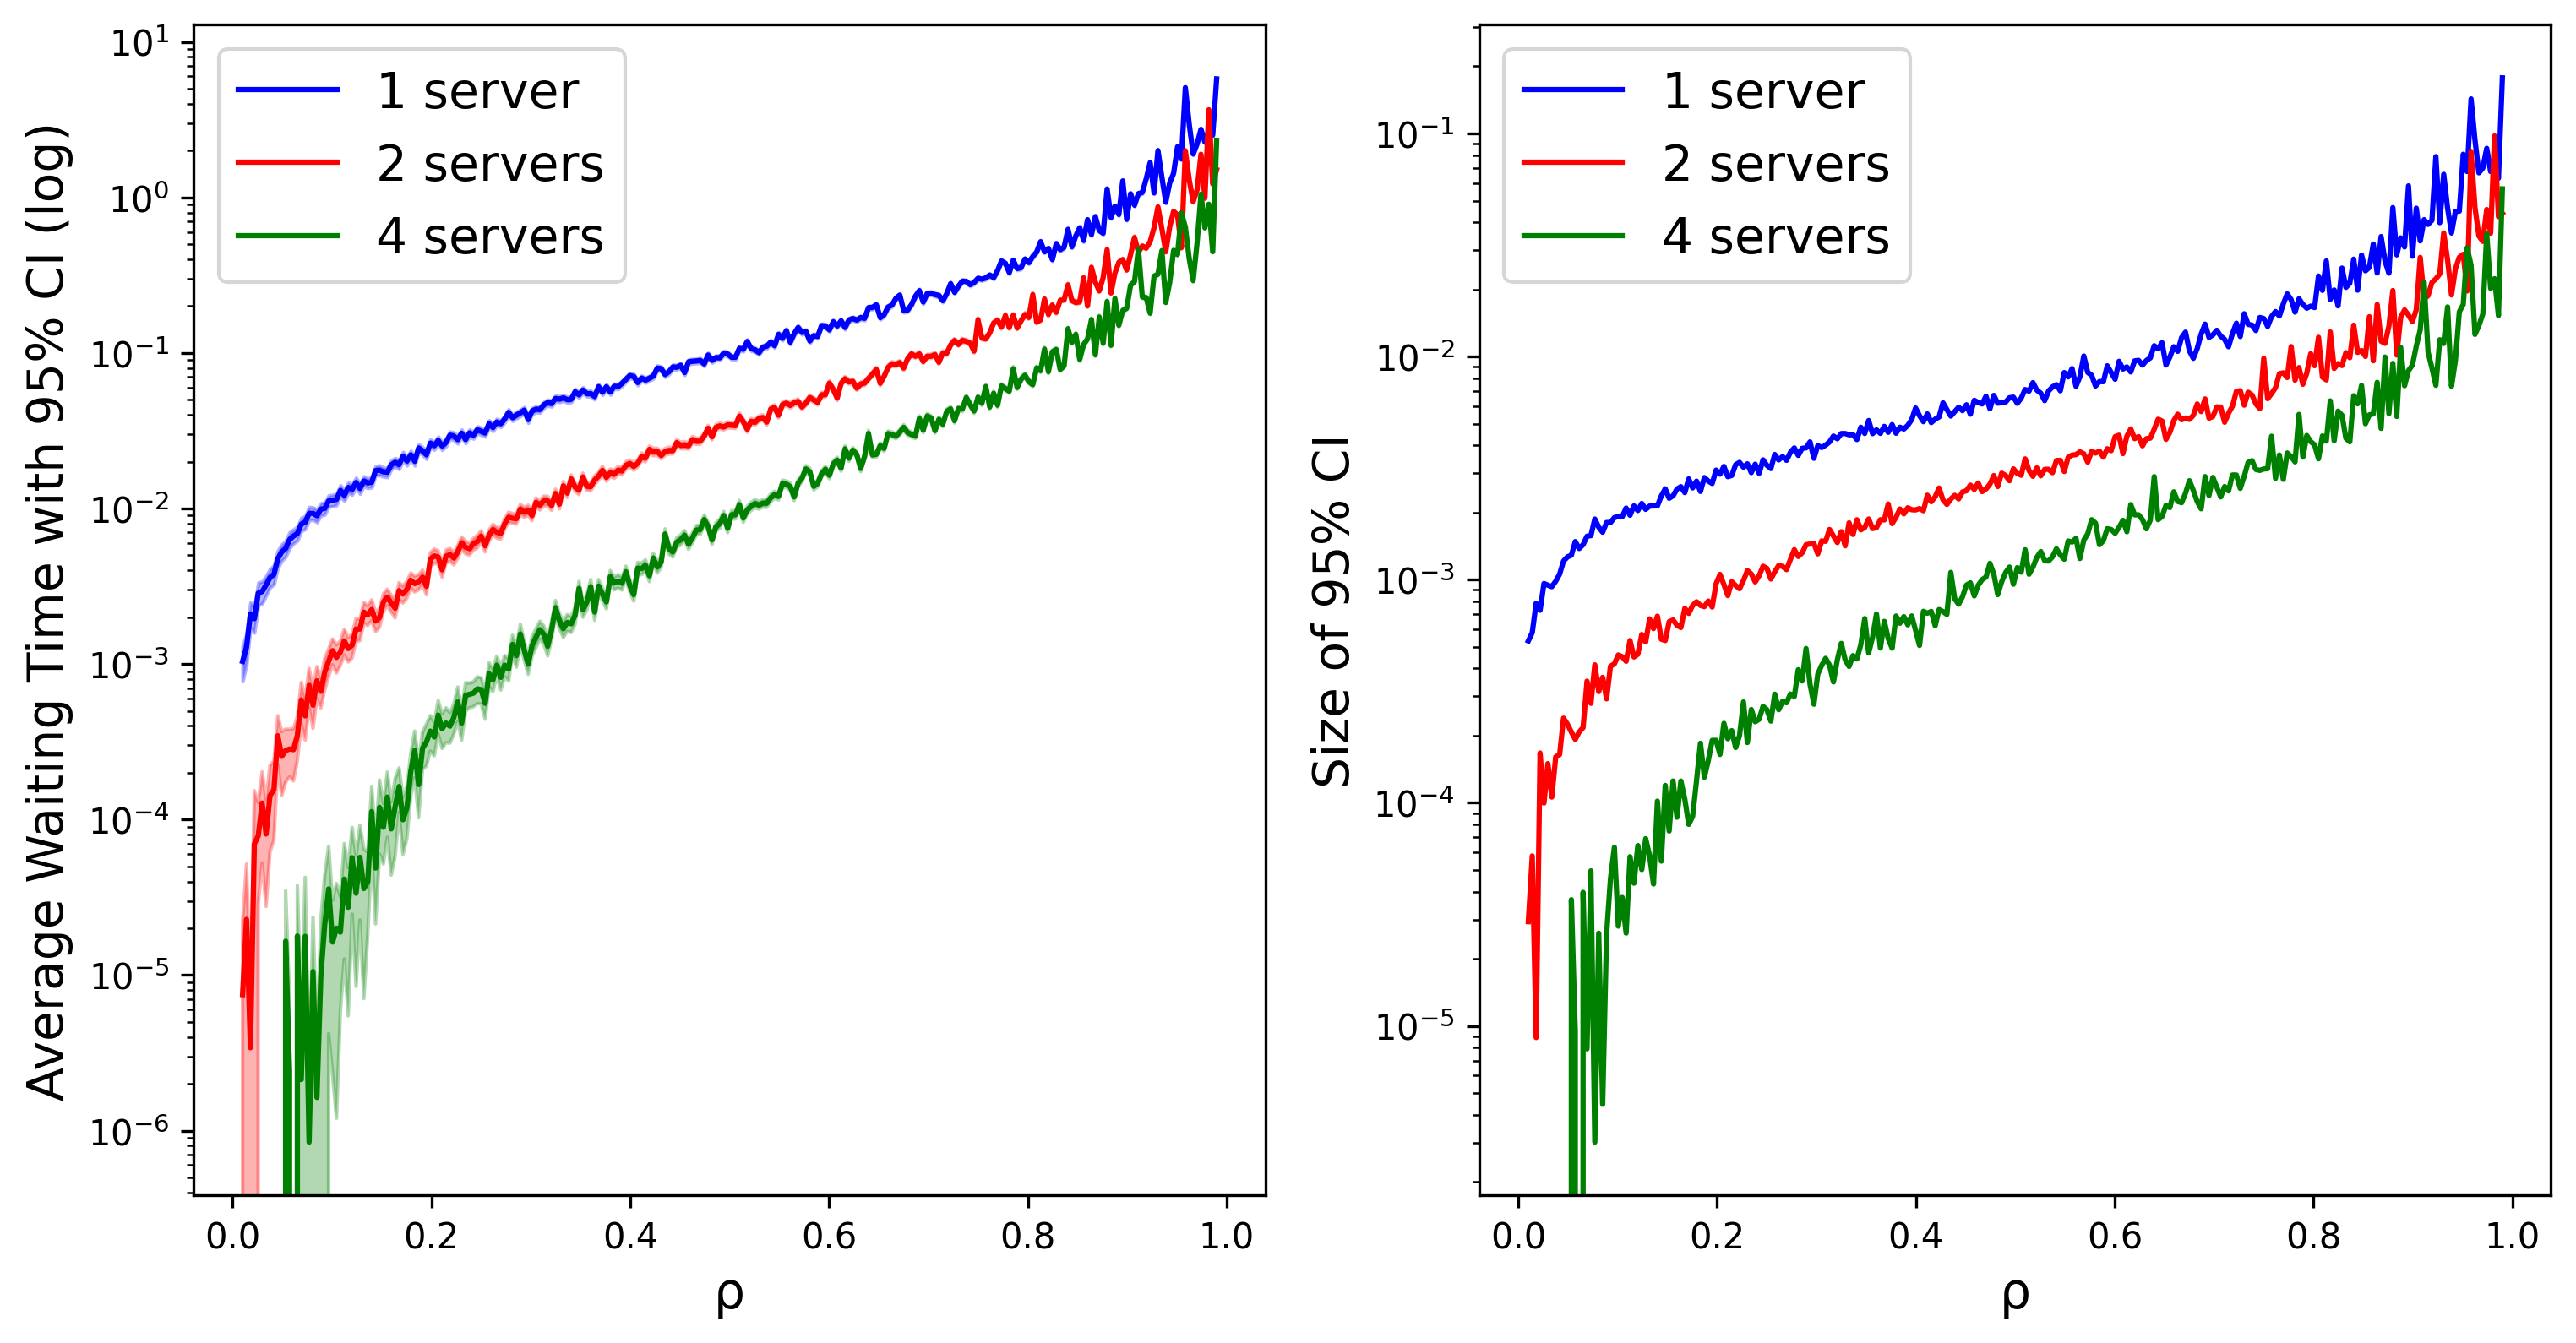

In [14]:
def queue_function(env, mu, waiting_times, res, completed_jobs): # Simulation for one single job

    arrival_time = env.now # Register time at which job arrives
        
    with res.request() as request:
        yield request # Join the queue
        waiting_times.append(env.now - arrival_time) # Calculate waiting time

        service_time = np.random.exponential(1 / mu) # Draw a random time from an exponential distribution with mean 1/mu ()
        yield env.timeout(service_time) # Add service time
        completed_jobs[0] += 1

def arrivals(env, lambda_, res, mu, waiting_times, completed_jobs, jobs): # Continuously create new jobs

    for _ in range(jobs):
        yield env.timeout(np.random.exponential(1 / lambda_)) # Pause time until next arrival (randomly drawn from exponential distribution)
        env.process(queue_function(env, mu, waiting_times, res, completed_jobs)) # Start new process for new job


def simulation(rho, mu, servers, jobs):

    lambda_ = rho * servers * mu # Derive Lambda so to compare queues with the same rho and same mu, as asked in the assignment
    env = simpy.Environment() # Create general environment
    res = simpy.Resource(env, capacity = servers) # Set number of servers
    waiting_times = []
    completed_jobs = [0]

    env.process(arrivals(env, lambda_, res, mu, waiting_times, completed_jobs, jobs)) # Start creating continuously new jobs

    while completed_jobs[0] < jobs:
        env.run() # Run simulation for expected time needed to get the number of jobs desired

    # Compute average waiting time and corresponding 95% confidence interval
    mean_waiting_time = np.mean(waiting_times)
    measurements = len(waiting_times)
    std_dev_waiting_time = np.std(waiting_times, ddof = 1)
    n = len(waiting_times)
    bound = z * (std_dev_waiting_time / np.sqrt(n))
    ci_low = mean_waiting_time - bound
    ci_high = mean_waiting_time + bound

    return mean_waiting_time, measurements, std_dev_waiting_time, (ci_low, ci_high)

# Set parameters
rhos = np.linspace(0.01, 0.99, 250) # System load
mu = 10 # Servers capacity
jobs = 10000 # Number of jobs to be completed
z = norm.ppf(0.975) # Z for confidence interval
colors = ['b', 'r', 'g']
labels = ['1 server', '2 servers', '4 servers']

# Run simulation for 1, 2 and 4 servers and plot the corresponding average waiting times and size of confidence intervals to evaluate how the number of measurements required to attain a certain statistical significance depend on ρ
fig, (ax1, ax2) = plt.subplots(1, 2, dpi = 300, figsize = (12, 6))

for i, servers in enumerate([1, 2, 4]):
    times = []
    ci_low = []
    ci_high = []
    diff = []

    for rho in rhos:
        avg_waiting_time, measurements, std, confidence_interval = simulation(rho, mu, servers, jobs)
        times.append(avg_waiting_time)
        ci_low.append(confidence_interval[0])
        ci_high.append(confidence_interval[1])
        diff.append(confidence_interval[1] - confidence_interval[0])

    ax1.plot(rhos, times, color = colors[i], label = labels[i])
    ax1.fill_between(rhos, ci_low, ci_high, color = colors[i], alpha = 0.3)

    ax2.plot(rhos, diff, color = colors[i], label = labels[i])

ax1.set_xlabel('ρ', fontsize = 14)
ax1.set_ylabel('Average Waiting Time with 95% CI (log)', fontsize = 14)
ax1.set_yscale('log')
ax1.legend(fontsize = 14)
ax2.set_xlabel('ρ', fontsize = 14)
ax2.set_ylabel('Size of 95% CI', fontsize = 14)
ax2.set_yscale('log')
ax2.legend(fontsize = 14)
plt.savefig('./figures/figure1.png')
plt.show()


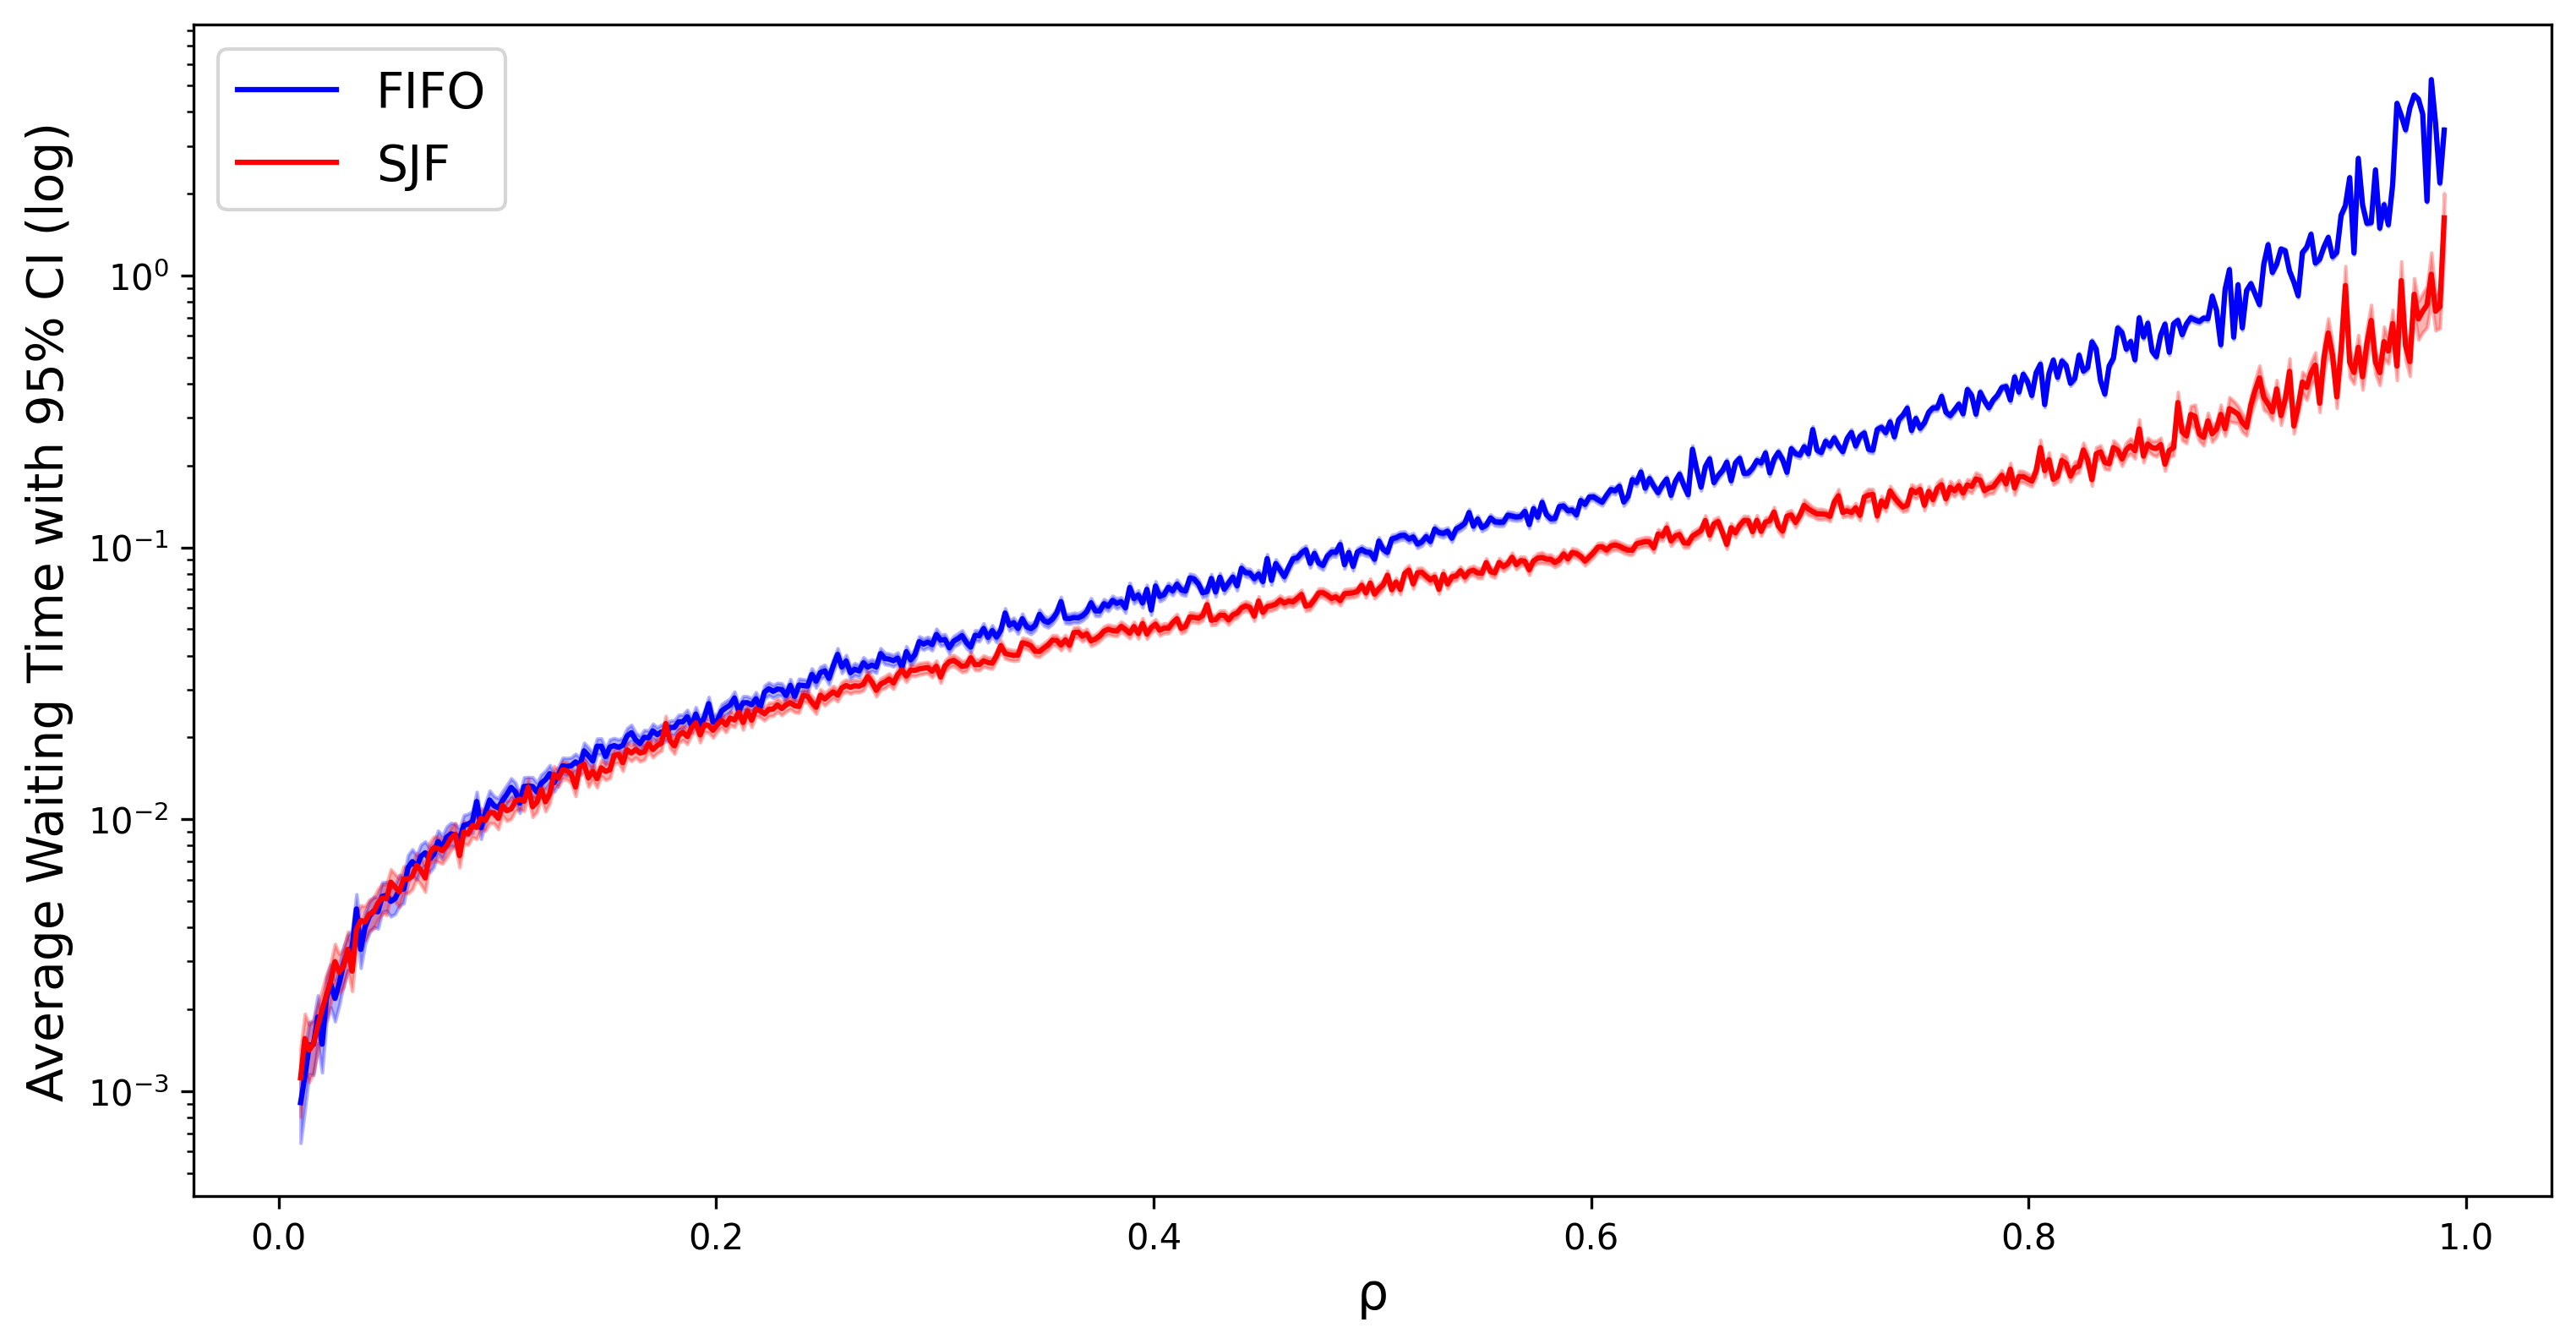

In [15]:
def queue_function_sjf(env, mu, waiting_times, res, completed_jobs): # Simulation for one single job

    arrival_time = env.now # Register time at which job arrives
    service_time = np.random.exponential(1 / mu) # Draw a random service time from an exponential distribution with mean 1/mu ()
        
    with res.request(priority = service_time) as request: # Prioratize requests with lower service time needed
        yield request # Join the queue
        waiting_times.append(env.now - arrival_time) # Calculate waiting time

        yield env.timeout(service_time) # Add service time
        completed_jobs[0] += 1

def arrivals_sjf(env, lambda_, res, mu, waiting_times, completed_jobs, jobs): # Continuously create new jobs

    for _ in range(jobs):
        yield env.timeout(np.random.exponential(1 / lambda_)) # Pause time until next arrival (randomly drawn from exponential distribution)
        env.process(queue_function_sjf(env, mu, waiting_times, res, completed_jobs)) # Start new process for new job


def simulation_sjf(rho, mu, servers, jobs):

    lambda_ = rho * servers * mu # Derive Lambda so to compare queues with the same rho and same mu, as asked in the assignment
    env = simpy.Environment() # Create general environment
    res = simpy.PriorityResource(env, capacity = servers) # Set number of servers
    waiting_times = []
    completed_jobs = [0]

    env.process(arrivals_sjf(env, lambda_, res, mu, waiting_times, completed_jobs, jobs)) # Start creating continuously new jobs

    while completed_jobs[0] < jobs:
        env.run() # Run simulation for expected time needed to get the number of jobs desired

    # Compute average waiting time and corresponding 95% confidence interval
    mean_waiting_time = np.mean(waiting_times)
    measurements = len(waiting_times)
    std_dev_waiting_time = np.std(waiting_times, ddof = 1)
    n = len(waiting_times)
    bound = z * (std_dev_waiting_time / np.sqrt(n))
    ci_low = mean_waiting_time - bound
    ci_high = mean_waiting_time + bound

    return mean_waiting_time, measurements, std_dev_waiting_time, (ci_low, ci_high)

# Set parameters
rhos = np.linspace(0.01, 0.99, 500) # System load
mu = 10 # Servers capacity
jobs = 10000 # Number of jobs to be completed
servers = 1 # Number of servers
z = norm.ppf(0.975) # Z for confidence interval
colors = ['b', 'r']
labels = ['FIFO', 'SJF']

# Run both types of simulations for different rhos (keeping mu constant) and plot the resulting average waiting times
plt.figure(dpi = 300, figsize = (12, 6))

for i, type in enumerate([simulation, simulation_sjf]):
    times = []
    ci_low = []
    ci_high = []

    for rho in rhos:
        avg_waiting_time, measurements, std, confidence_interval = type(rho, mu, servers, jobs)
        times.append(avg_waiting_time)
        ci_low.append(confidence_interval[0])
        ci_high.append(confidence_interval[1])

    plt.plot(rhos, times, color = colors[i], label = labels[i])
    plt.fill_between(rhos, ci_low, ci_high, color = colors[i], alpha = 0.3)

plt.xlabel('ρ', fontsize = 14)
plt.ylabel('Average Waiting Time with 95% CI (log)', fontsize = 14)
plt.yscale('log')
plt.legend(fontsize = 14)
plt.savefig('./figures/figure2.png')
plt.show()


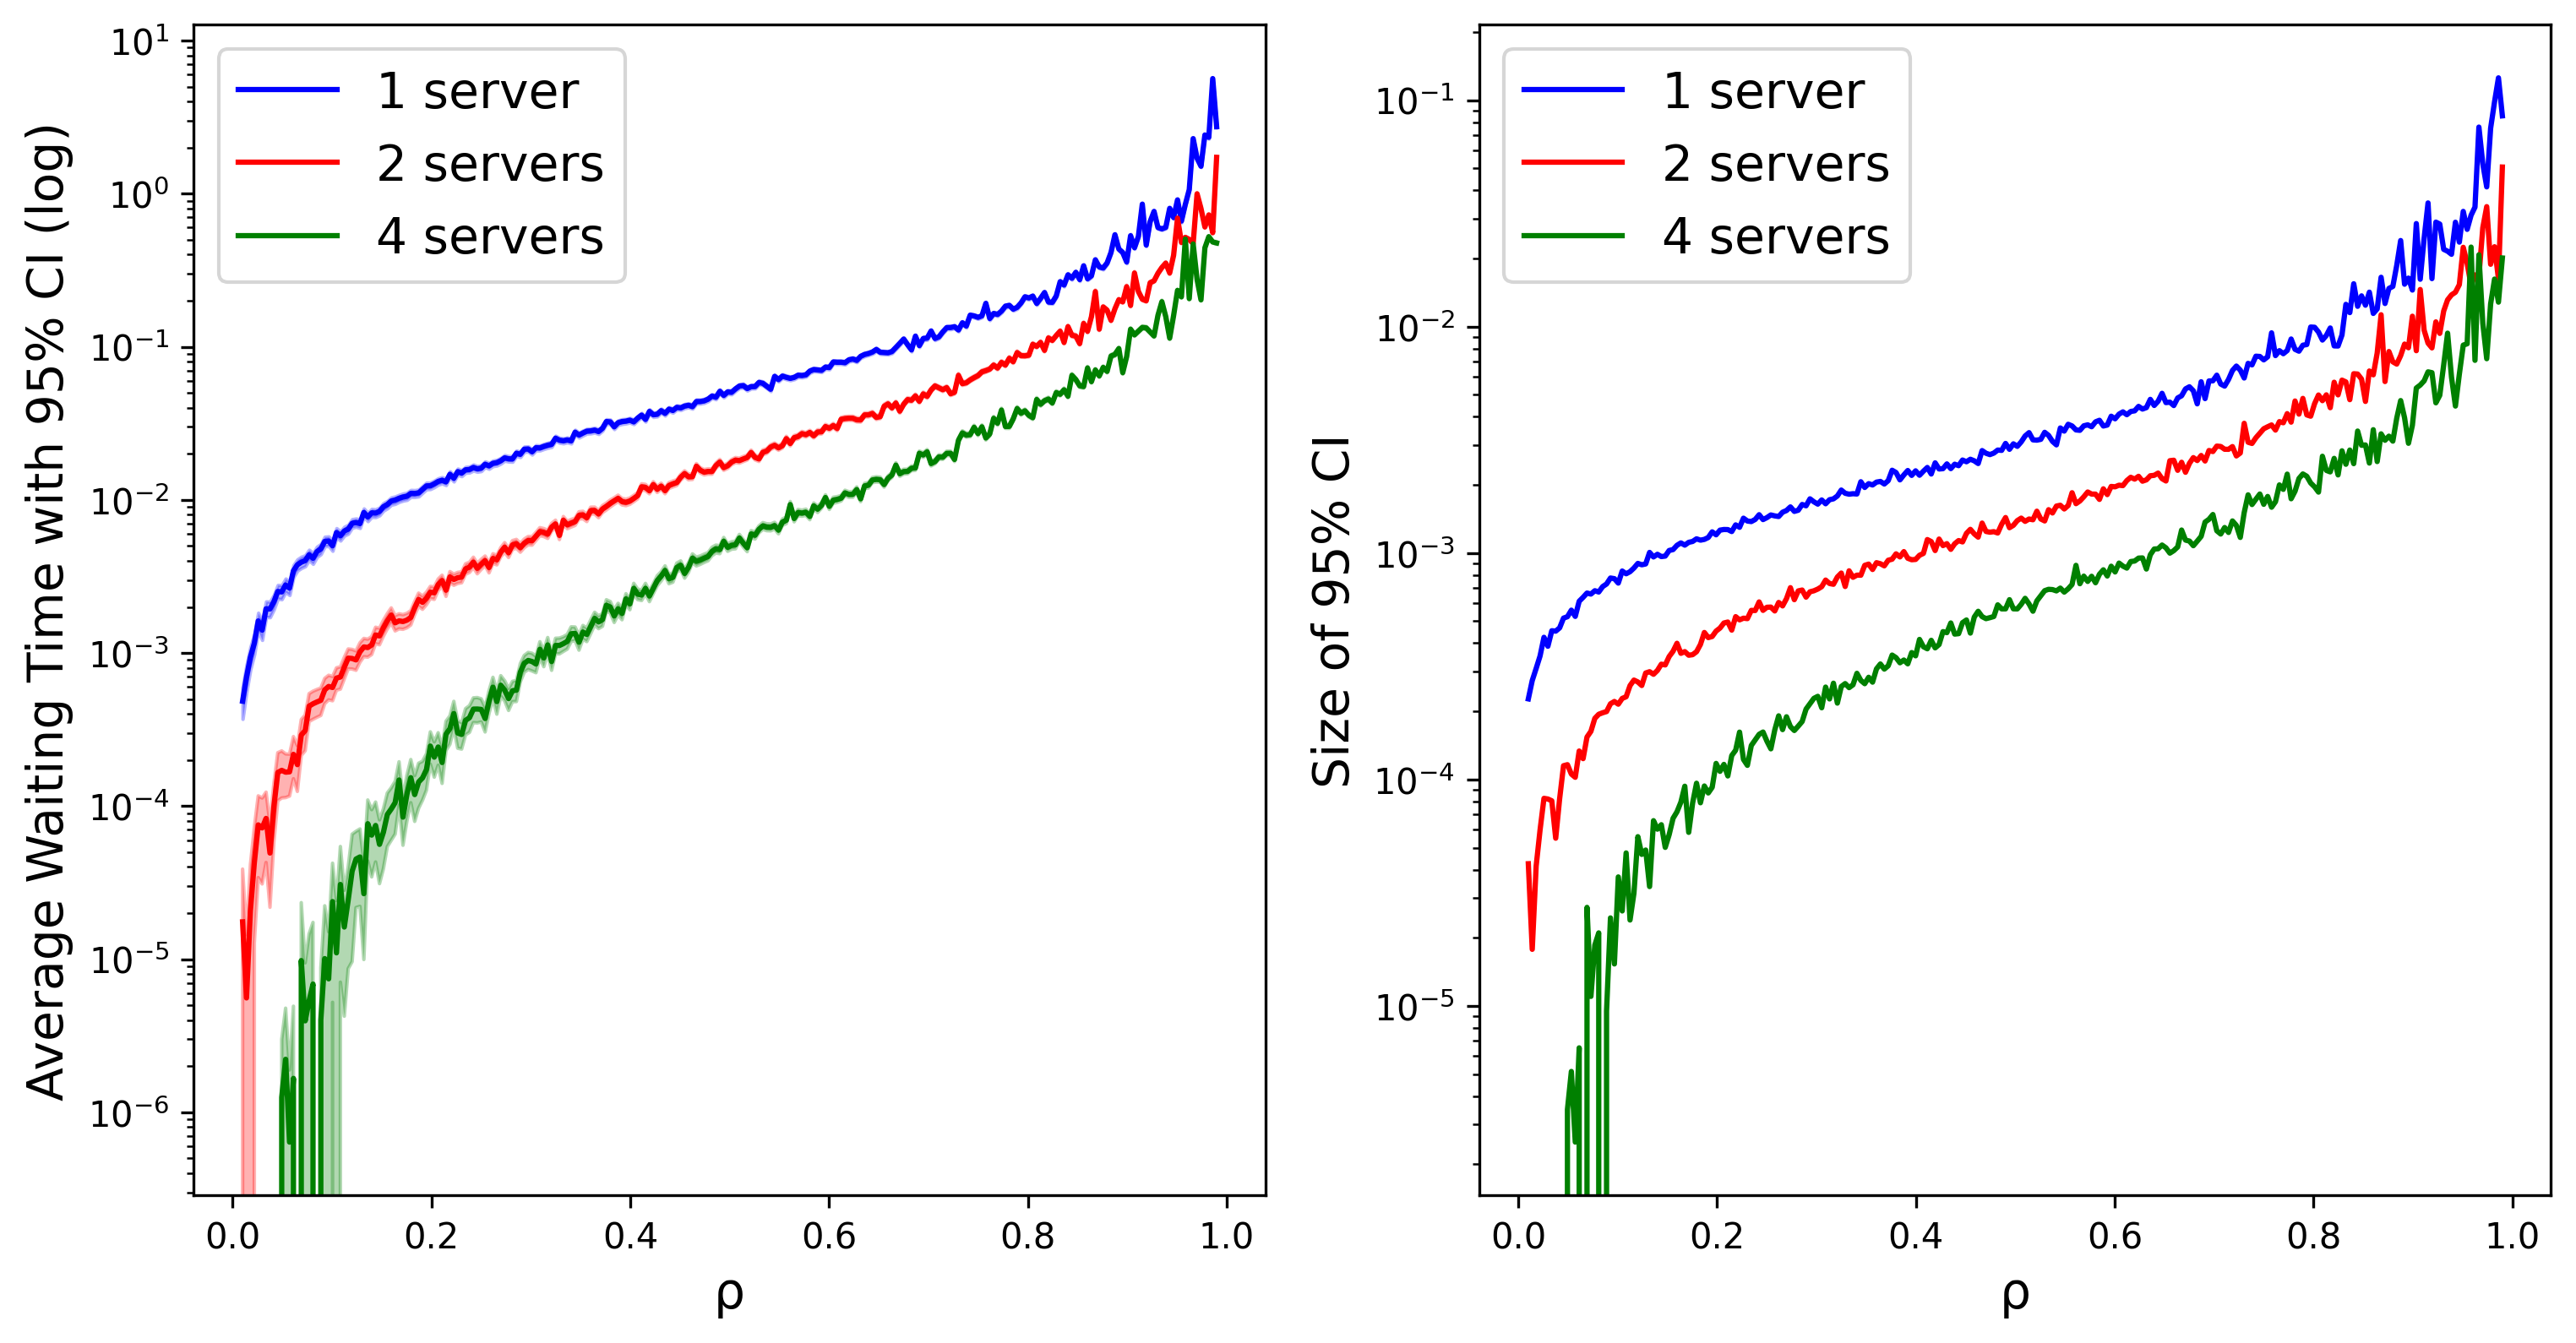

In [16]:
#SET DETERMINISTIC JOB SERVICE TIME \mu

def queue_function_d(env, mu, waiting_times, res, completed_jobs): # Simulation for one single job

    arrival_time = env.now # Register time at which job arrives
        
    with res.request() as request:
        yield request # Join the queue
        waiting_times.append(env.now - arrival_time) # Calculate waiting time

        service_time = 1 / mu # Fixed _Service Rate_ value for the DETERMINISTIC solution
        yield env.timeout(service_time) # Add service time
        completed_jobs[0] += 1

def arrivals_d(env, lambda_, res, mu, waiting_times, completed_jobs, jobs): # Continuously create new jobs

    for _ in range(jobs):
        yield env.timeout(np.random.exponential(1 / lambda_)) # Pause time until next arrival (randomly drawn from exponential distribution)
        env.process(queue_function_d(env, mu, waiting_times, res, completed_jobs)) # Start new process for new job

def simulation_d(rho, mu, servers, jobs):

    lambda_ = rho * servers * mu # Derive Lambda so to compare queues with the same rho and same mu, as asked in the assignment
    env = simpy.Environment() # Create general environment
    res = simpy.Resource(env, capacity = servers) # Set number of servers
    waiting_times = []
    completed_jobs = [0]

    env.process(arrivals_d(env, lambda_, res, mu, waiting_times, completed_jobs, jobs)) # Start creating continuously new jobs

    while completed_jobs[0] < jobs:
        env.run() # Run simulation for expected time needed to get the number of jobs desired

    # Compute average waiting time and corresponding 95% confidence interval
    mean_waiting_time = np.mean(waiting_times)
    measurements = len(waiting_times)
    std_dev_waiting_time = np.std(waiting_times, ddof = 1)
    n = len(waiting_times)
    bound = z * (std_dev_waiting_time / np.sqrt(n))
    ci_low = mean_waiting_time - bound
    ci_high = mean_waiting_time + bound

    return mean_waiting_time, measurements, std_dev_waiting_time, (ci_low, ci_high)

# Set parameters
rhos = np.linspace(0.01, 0.99, 250) # System load
mu = 10 # Servers capacity
jobs = 10000 # Number of jobs to be completed
z = norm.ppf(0.975) # Z for confidence interval
colors = ['b', 'r', 'g']
labels = ['1 server', '2 servers', '4 servers']

# Run simulation for 1, 2 and 4 servers and plot the corresponding average waiting times and size of confidence intervals to evaluate how the number of measurements required to attain a certain statistical significance depend on ρ
fig, (ax1, ax2) = plt.subplots(1, 2, dpi = 300, figsize = (12, 6))

for i, servers in enumerate([1, 2, 4]):
    times = []
    ci_low = []
    ci_high = []
    diff = []

    for rho in rhos:
        avg_waiting_time, measurements, std, confidence_interval = simulation_d(rho, mu, servers, jobs)
        times.append(avg_waiting_time)
        ci_low.append(confidence_interval[0])
        ci_high.append(confidence_interval[1])
        diff.append(confidence_interval[1] - confidence_interval[0])

    ax1.plot(rhos, times, color = colors[i], label = labels[i])
    ax1.fill_between(rhos, ci_low, ci_high, color = colors[i], alpha = 0.3)

    ax2.plot(rhos, diff, color = colors[i], label = labels[i])

ax1.set_xlabel('ρ', fontsize = 14)
ax1.set_ylabel('Average Waiting Time with 95% CI (log)', fontsize = 14)
ax1.set_yscale('log')
ax1.legend(fontsize = 14)
ax2.set_xlabel('ρ', fontsize = 14)
ax2.set_ylabel('Size of 95% CI', fontsize = 14)
ax2.set_yscale('log')
ax2.legend(fontsize = 14)
plt.savefig('./figures/figure3.png')
plt.show()

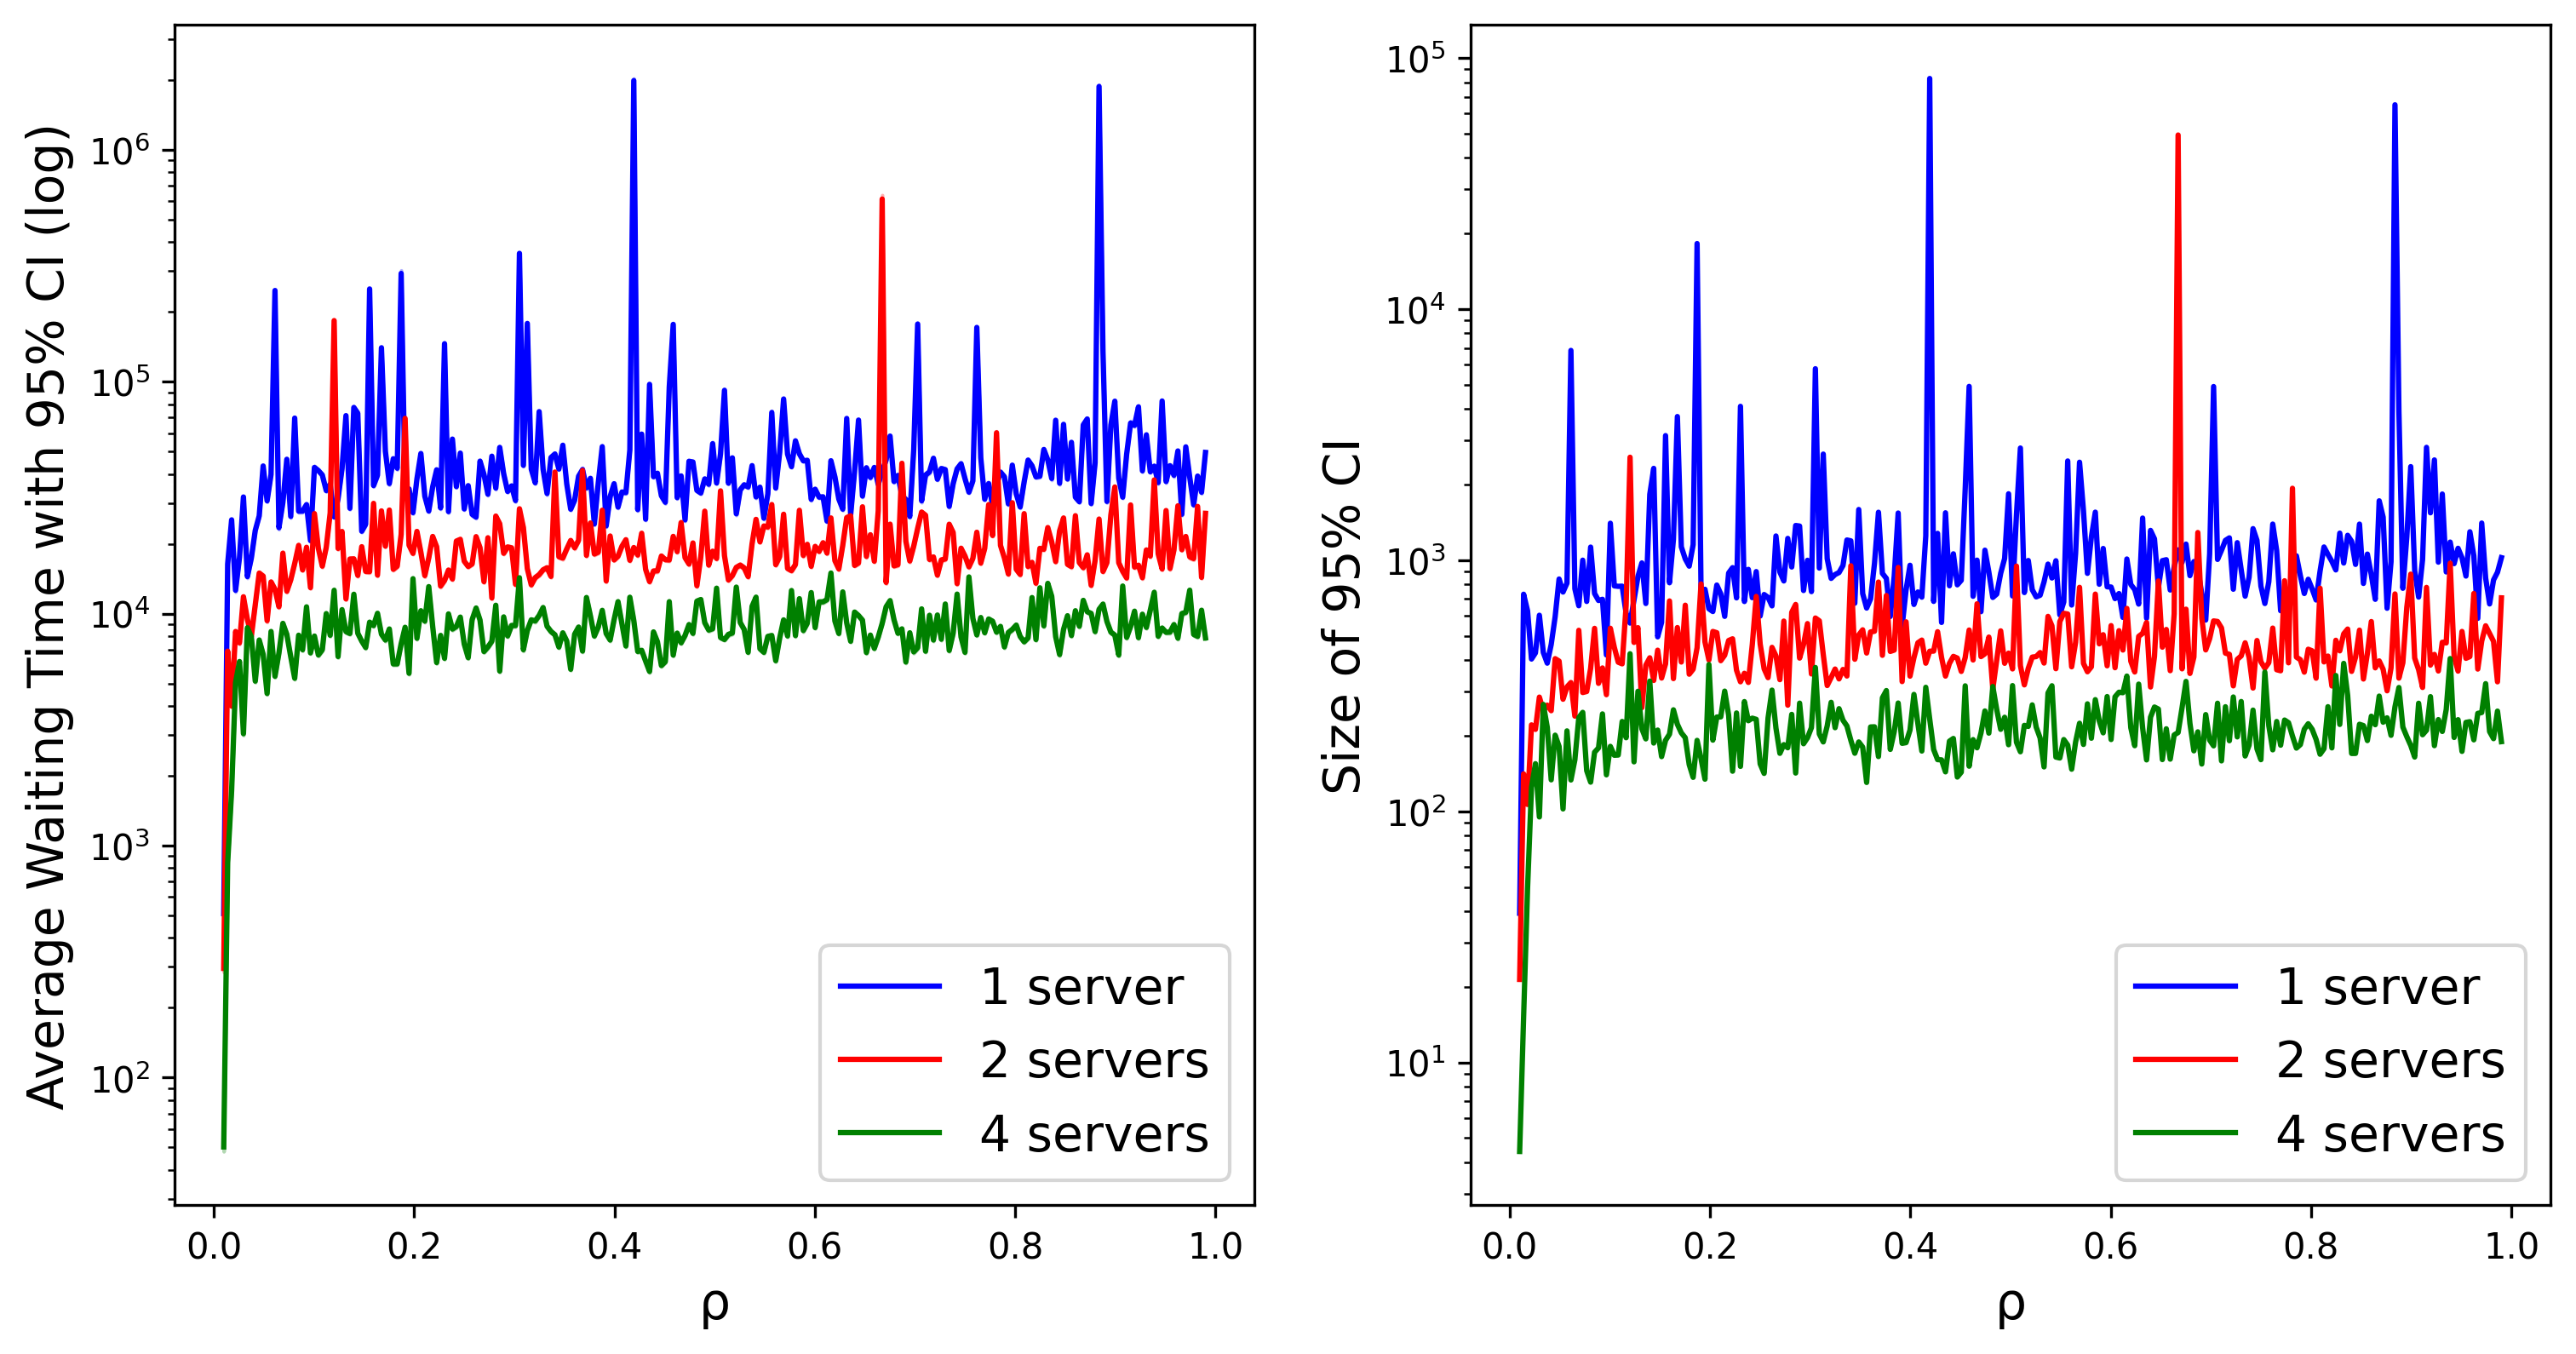

In [17]:
#CREATE LONG-TAIL DISTRIBUTION
def hyper_exponential():
    if np.random.rand() < 0.75:
        return np.random.exponential(1.0)
    else:
        return np.random.exponential(5.0)

def queue_function_lt(env, mu, waiting_times, res, completed_jobs): # Simulation for one single job

    arrival_time = env.now # Register time at which job arrives
        
    with res.request() as request:
        yield request # Join the queue
        waiting_times.append(env.now - arrival_time) # Calculate waiting time

        service_time = 1 / hyper_exponential() # Long-tailed distribution of _Service Rate_ value
        yield env.timeout(service_time) # Add service time
        completed_jobs[0] += 1

def arrivals_lt(env, lambda_, res, mu, waiting_times, completed_jobs, jobs): # Continuously create new jobs

    for _ in range(jobs):
        yield env.timeout(np.random.exponential(1 / lambda_)) # Pause time until next arrival (randomly drawn from exponential distribution)
        env.process(queue_function_lt(env, mu, waiting_times, res, completed_jobs)) # Start new process for new job

def simulation_lt(rho, mu, servers, jobs):

    lambda_ = rho * servers * mu # Derive Lambda so to compare queues with the same rho and same mu, as asked in the assignment
    env = simpy.Environment() # Create general environment
    res = simpy.Resource(env, capacity = servers) # Set number of servers
    waiting_times = []
    completed_jobs = [0]

    env.process(arrivals_lt(env, lambda_, res, mu, waiting_times, completed_jobs, jobs)) # Start creating continuously new jobs

    while completed_jobs[0] < jobs:
        env.run() # Run simulation for expected time needed to get the number of jobs desired

    # Compute average waiting time and corresponding 95% confidence interval
    mean_waiting_time = np.mean(waiting_times)
    measurements = len(waiting_times)
    std_dev_waiting_time = np.std(waiting_times, ddof = 1)
    n = len(waiting_times)
    bound = z * (std_dev_waiting_time / np.sqrt(n))
    ci_low = mean_waiting_time - bound
    ci_high = mean_waiting_time + bound

    return mean_waiting_time, measurements, std_dev_waiting_time, (ci_low, ci_high)

# Set parameters
rhos = np.linspace(0.01, 0.99, 250) # System load
mu = 10 # Servers capacity
jobs = 10000 # Number of jobs to be completed
z = norm.ppf(0.975) # Z for confidence interval
colors = ['b', 'r', 'g']
labels = ['1 server', '2 servers', '4 servers']

# Run simulation for 1, 2 and 4 servers and plot the corresponding average waiting times and size of confidence intervals to evaluate how the number of measurements required to attain a certain statistical significance depend on ρ
fig, (ax1, ax2) = plt.subplots(1, 2, dpi = 300, figsize = (12, 6))

for i, servers in enumerate([1, 2, 4]):
    times = []
    ci_low = []
    ci_high = []
    diff = []

    for rho in rhos:
        avg_waiting_time, measurements, std, confidence_interval = simulation_lt(rho, mu, servers, jobs)
        times.append(avg_waiting_time)
        ci_low.append(confidence_interval[0])
        ci_high.append(confidence_interval[1])
        diff.append(confidence_interval[1] - confidence_interval[0])

    ax1.plot(rhos, times, color = colors[i], label = labels[i])
    ax1.fill_between(rhos, ci_low, ci_high, color = colors[i], alpha = 0.3)

    ax2.plot(rhos, diff, color = colors[i], label = labels[i])

ax1.set_xlabel('ρ', fontsize = 14)
ax1.set_ylabel('Average Waiting Time with 95% CI (log)', fontsize = 14)
ax1.set_yscale('log')
ax1.legend(fontsize = 14)
ax2.set_xlabel('ρ', fontsize = 14)
ax2.set_ylabel('Size of 95% CI', fontsize = 14)
ax2.set_yscale('log')
ax2.legend(fontsize = 14)
plt.savefig('./figures/figure4.png')
plt.show()